## Figure 2. Geodetic Modeling Results.

The following steps are required before running the notebook.

1. [Prepare GBIS input file](GBIS_1_prep_input.ipynb)
2. Run GBIS in Matlab
3. [Load GBIS inversion result into HDF5 file](GBIS_2_load_inv_result.ipynb)

In [1]:
%matplotlib inline
import os
import glob
import numpy as np
from cartopy import crs as ccrs
from pprint import pprint
from matplotlib import pyplot as plt, ticker
from mintpy.utils import ptime, readfile, utils as ut, plot as pp
from mintpy.defaults.plot import *
from mintpy import view

work_dir = os.path.expanduser('~/Papers/2021_Kirishima/figs_src/obs_vs_model')
os.chdir(work_dir)
print('Go to directory', work_dir)

## Data Info
# Shinmoe-dake crater ring lon/lat
crater_lonlat_file = os.path.expanduser('~/Papers/2021_Kirishima/figs_src/data/Shinmoe_crater_lonlat.xy')
fc = np.loadtxt(crater_lonlat_file, dtype=bytes, comments='>').astype(float)
crater_lons = fc[:,0]
crater_lats = fc[:,1]

# Shinmoe-dake vent of the 2008 phreatic eruption
vent_lalo = [31.9113, 130.8795]  #S-17 in Fig. 2 (Geshi et al., 2010)
# Iwo-yama fluid sample (Tajima et al., 2020)
Y1_lalo = [31.9458, 130.8530]    #Hydrothermal pond Y1 at 16 Apr 2018
K3_lalo = [31.9475, 130.8511]    #Spring K3 at 16/21 Feb and 12/30 Mar 2016

# DEM and inversion result dir
dem_file = os.path.expanduser('~/data/archives/Kirishima/DEM/gsi10m.dem.wgs84')
inv_res_dir = os.path.expanduser('~/Papers/2021_Kirishima/figs_src/model')

# inversion dataset
ds_list = [
    'Shinmoe2008post/invert_1_2_C',
    'Shinmoe2017pre/invert_1_2_C',
    'Iwo2017pre/invert_1_2_C',
    'Iwo2017post/invert_1_2_C_C2',
]

model_lalos = [
    [31.9125, 130.8845],
    [31.9111, 130.8828],
    [31.9470, 130.8532],
    [31.9464, 130.8530],
]

Go to directory /Users/yunjunz/Papers/2021_Kirishima/figs_src/obs_vs_model


### Utilities function

In [2]:
def plot_data_model_map(fnames, sub, defo_name, profile=None, model_lalo=None, figsize=[3.6, 3.0]):
    # input dataset
    cmd0s = [
        'view.py {} data'.format(fnames[0]),
        'view.py {} data'.format(fnames[1]),
        'view.py {} model'.format(fnames[0]),
        'view.py {} model'.format(fnames[1]),
    ]

    # options for view.py
    opt = ' --noverbose --notitle --nocbar --notick --ref-size 2 --fontsize 12 ' #--notick
    opt += ' -u cm --wrap --wrap-range -5 5 -c cmy --noreference '
    if 'Shinmoe' in defo_name:
        opt += ' --scalebar 0.3 0.25 0.075 --scalebar-pad 0.1 '
    else:
        opt += ' --scalebar 0.5 0.30 0.075 --scalebar-pad 0.1 '

    # plot
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize)
    axs = axs.flatten()
    for i in range(len(axs)):
        ax = axs[i]

        # plot displacement
        cmd = cmd0s[i]+opt+sub
        if i != 2:
            cmd += ' --noscalebar'
        d_v, atr, inps = view.prep_slice(cmd)
        im, cbar = view.plot_slice(ax, d_v, atr, inps)[2:4]

        # plot profile
        if profile is not None:
            [[lat0, lon0], [lat1, lon1]] = profile
            ax.plot([lon0,lon1], [lat0,lat1], 'k--', lw=1)

        # annotation for Shinmoe-dake
        if 'Shinmoe' in defo_name:
            # plot the ring of the crater
            ax.plot(crater_lons, crater_lats, 'k-', lw=0.5)

            # plot the vent location
            if 'Shinmoe2008' in defo_name and i in [2,3]:
                ax.plot(vent_lalo[1], vent_lalo[0], '^', ms=6, lw=0.5, alpha=1, mfc='k', mec='k')

            # plot model centroid location
            if model_lalo is not None and i in [2,3]:
                ax.plot(model_lalo[1], model_lalo[0], '*', ms=9, lw=0.5, alpha=1, mfc='k', mec='k')

        #elif 'Iwo' in defo_name:
        #    if i in [2,3]:
        #        ax.plot(Y1_lalo[1], Y1_lalo[0], 'o', ms=6, lw=0.5, alpha=1, mfc='none', mec='k')
        #        ax.plot(K3_lalo[1], K3_lalo[0], 'o', ms=6, lw=0.5, alpha=1, mfc='none', mec='k')
    fig.subplots_adjust(wspace=0.05, hspace=0.03, left=0.05, right=0.95, top=0.95, bottom=0.05)

    # output
    out_file = os.path.abspath('{}_map.png'.format(defo_name))
    if save_fig:
        plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
    print('save figure to', out_file)
    return fig, axs, im


def get_data_model_transection(inv_file, profile):
    # data
    data, atr = readfile.read(inv_file, datasetName='data')
    txn_data  = ut.transect_lalo(data, atr, start_lalo=profile[0], end_lalo=profile[1])
    # model
    data, atr = readfile.read(inv_file, datasetName='model')
    txn_model = ut.transect_lalo(data, atr, start_lalo=profile[0], end_lalo=profile[1])
    # output
    txn = dict()
    txn['distance'] = txn_data['distance'] / 1000.   #km
    txn['data'] = txn_data['value'] * 100.           #cm
    txn['model'] = txn_model['value'] * 100.         #cm
    return txn


def plot_data_model_profile(fnames, profile, dem_file, defo_name, offset=15, ylim=[-30,15], figsize=[1.7, 1.7]):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

    # plot displacement - ax
    colors = [pp.mplColors[1], pp.mplColors[0]]
    for i in range(len(fnames)):
        off = (1-i)*offset + 10
        txn = get_data_model_transection(fnames[i], profile)
        ax.scatter(txn['distance'], txn['data']+off, facecolors='none', edgecolors=colors[i], s=3**2, alpha=0.5, label='data')
        ax.plot(txn['distance'], txn['model']+off, c=colors[i], lw=2, label='model')

    # plot topography - ax2
    data, atr = readfile.read(dem_file)
    txn2 = ut.transect_lalo(data, atr, start_lalo=profile[0], end_lalo=profile[1])
    ax2 = ax.twinx()
    ax2.fill_between(txn2['distance']/1000., txn2['value']/1000., facecolor='gray', alpha=0.3, zorder=0)

    # axis format - ax
    ax.set_xlim(0, np.max(txn['distance']))
    ax.set_ylim(ylim)
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)

    # axis format - ax2
    ax2.set_ylim(1.0, 4.5)
    ax2.set_yticks(np.arange(0.5, 1.6, 0.5))
    ax2.tick_params(which='both', direction='out', colors='k', labelsize=font_size, bottom=True, top=False, left=False, right=True)

    # axis ticklabel
    ax.set_xlabel('distance [km]', fontsize=font_size)
    if defo_name in ['Iwo2017pre', 'Shinmoe2008post']:
        ax2.get_yaxis().set_ticklabels([])
        ax.set_ylabel('LOS displacement [cm]', fontsize=font_size, y=0.36)
    else:
        ax2.set_ylabel('elevation [km]', fontsize=font_size, y=0.13)
    fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

    # output
    out_file = os.path.abspath('{}_profile.png'.format(defo_name))
    if save_fig:
        plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
    print('save figure to', out_file)
    return fig, ax

print('Utilities functions initiated.')

Utilities functions initiated.


### Plot

read data from files:
['/Users/yunjunz/Papers/2021_Kirishima/figs_src/model/Shinmoe2008post/invert_1_2_C/KirishimaAlosAT424_20080929_20100705.h5',
 '/Users/yunjunz/Papers/2021_Kirishima/figs_src/model/Shinmoe2008post/invert_1_2_C/KirishimaAlosDT73_20081012_20100302.h5']
save figure to /Users/yunjunz/Papers/2021_Kirishima/figs_src/obs_vs_model/Shinmoe2008post_map.png
save figure to /Users/yunjunz/Papers/2021_Kirishima/figs_src/obs_vs_model/Shinmoe2008post_profile.png


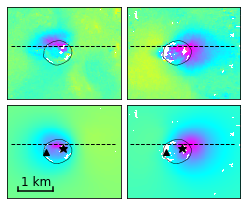

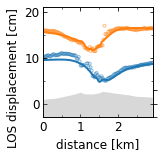

read data from files:
['/Users/yunjunz/Papers/2021_Kirishima/figs_src/model/Shinmoe2017pre/invert_1_2_C/KirishimaAlos2AT131_20150106_20171010.h5',
 '/Users/yunjunz/Papers/2021_Kirishima/figs_src/model/Shinmoe2017pre/invert_1_2_C/KirishimaAlos2DT23_20150209_20170918.h5']
save figure to /Users/yunjunz/Papers/2021_Kirishima/figs_src/obs_vs_model/Shinmoe2017pre_map.png
save figure to /Users/yunjunz/Papers/2021_Kirishima/figs_src/obs_vs_model/Shinmoe2017pre_profile.png


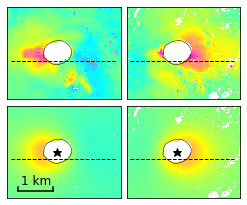

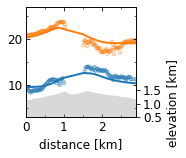

read data from files:
['/Users/yunjunz/Papers/2021_Kirishima/figs_src/model/Iwo2017pre/invert_1_2_C/KirishimaAlos2AT131_20150106_20171010.h5',
 '/Users/yunjunz/Papers/2021_Kirishima/figs_src/model/Iwo2017pre/invert_1_2_C/KirishimaAlos2DT23_20150209_20170918.h5']
save figure to /Users/yunjunz/Papers/2021_Kirishima/figs_src/obs_vs_model/Iwo2017pre_map.png
save figure to /Users/yunjunz/Papers/2021_Kirishima/figs_src/obs_vs_model/Iwo2017pre_profile.png


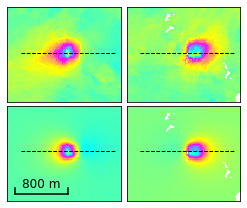

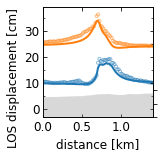

read data from files:
['/Users/yunjunz/Papers/2021_Kirishima/figs_src/model/Iwo2017post/invert_1_2_C_C2/KirishimaAlos2AT131_20171219_20190702.h5',
 '/Users/yunjunz/Papers/2021_Kirishima/figs_src/model/Iwo2017post/invert_1_2_C_C2/KirishimaAlos2DT23_20171211_20190819.h5']
save figure to /Users/yunjunz/Papers/2021_Kirishima/figs_src/obs_vs_model/Iwo2017post_map.png
save figure to /Users/yunjunz/Papers/2021_Kirishima/figs_src/obs_vs_model/Iwo2017post_profile.png


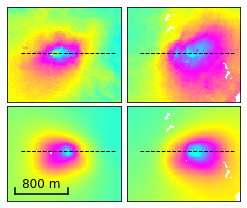

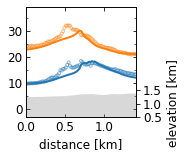

Done.


In [4]:
## Plot Configurations
subsets = [
    ' --sub-lat 31.8975 31.925 --sub-lon 130.868 130.902 ',  # Shinmoe 2008 post
    ' --sub-lat 31.8975 31.925 --sub-lon 130.868 130.902 ',  # Shinmoe 2017 pre
    ' --sub-lat 31.939  31.954 --sub-lon 130.843 130.861 ',  # Iwo 2017 pre
    ' --sub-lat 31.939  31.954 --sub-lon 130.843 130.861 ',  # Iwo 2017 post
#   ' --sub-lat 31.936  31.956 --sub-lon 130.840 130.864 ',  # Iwo 2017 post
]

profiles = [
    [[31.9136, 130.869 ], [31.9136, 130.900]],   #[[31.915, 130.865], [31.915, 130.900]],
    [[31.909 , 130.869 ], [31.909 , 130.900]],
    [[31.947 , 130.845 ], [31.947 , 130.860]],   #Iwo-yama at 0.8 km
    [[31.947 , 130.845 ], [31.947 , 130.860]],
]

lalo_Iwo = 31.9471, 130.8533

ylims = [
    [-3, 21],
    [ 3, 27],
    [-3, 39],
    [-3, 39],
]

offsets = [6, 10, 15, 12]

save_fig = True

## Plot
for i in range(len(ds_list)):
    defo_name, model_name = ds_list[i].split('/')
    fnames = sorted(glob.glob(os.path.join(inv_res_dir, defo_name, model_name, 'Kirishima*.h5')))
    print('read data from files:')
    pprint(fnames)

    # plot map
    fig, axs, im = plot_data_model_map(fnames, subsets[i], defo_name=defo_name, profile=profiles[i], model_lalo=model_lalos[i])

    # plot profile
    fig, ax = plot_data_model_profile(fnames, profiles[i], dem_file, defo_name=defo_name, offset=offsets[i], ylim=ylims[i])

    plt.show()
print('Done.')

### Colorbar & Legend

save figure to file /Users/yunjunz/Papers/2021_Kirishima/figs_src/obs_vs_model/map_cbar.png


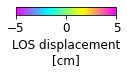

In [5]:
## Plot colorbar
fig, cax = plt.subplots(nrows=1, ncols=1, figsize=[1.8, 0.15])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal', ticks=[-5, 0, 5])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('LOS displacement\n[cm]', fontsize=font_size)
#cbar.ax.xaxis.set_label_position("top")

# output
out_file = os.path.abspath('map_cbar.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to file', out_file)
plt.show()

save figure to file /Users/yunjunz/Papers/2021_Kirishima/figs_src/obs_vs_model/profile_legend.png


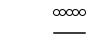

In [6]:
# legend
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[1.5, 0.5])
ax.plot([3.0,3.4,3.8,4.2,4.6],[5,5,5,5,5], 'ko', fillstyle='none')
ax.plot([2.9,4.8],[1,1], 'k-')

ax.axis('off')
ax.set_xlim(0, 6)
ax.set_ylim(0, 6)
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

out_file = os.path.abspath('profile_legend.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to file', out_file)
plt.show()

## Figure S24. Residual (obs - model) at Iwo-yama after Dec 2017

read mat file: /Users/yunjunz/Papers/2021_Kirishima/figs_src/model/Iwo2017post/invert_1_2_C_C2/invert_1_2_C_C2.mat
number of output HDF5 file: 2
creating figure in size of [12, 6]
------------------------------
read mask from file: /Users/yunjunz/Papers/2021_Kirishima/figs_src/model/data/KirishimaAlos2AT131_20171219_20190702.mat
delete exsited file: /Users/yunjunz/Papers/2021_Kirishima/figs_src/model/Iwo2017post/invert_1_2_C_C2/KirishimaAlos2AT131_20171219_20190702.h5
create HDF5 file: /Users/yunjunz/Papers/2021_Kirishima/figs_src/model/Iwo2017post/invert_1_2_C_C2/KirishimaAlos2AT131_20171219_20190702.h5 with w mode
create dataset /hgt      of float32    in size of (541, 541)           with compression=None
create dataset /data     of float32    in size of (541, 541)           with compression=None
create dataset /model    of float32    in size of (541, 541)           with compression=None
create dataset /residual of float32    in size of (541, 541)           with compression=None
fini

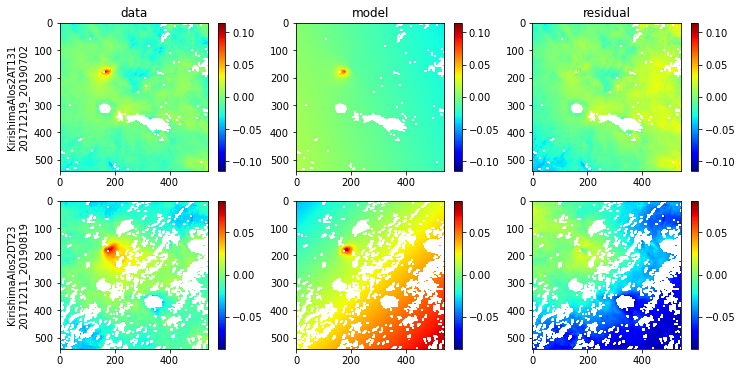

['/Users/yunjunz/Papers/2021_Kirishima/figs_src/model/Iwo2017post/invert_1_2_C_C2/KirishimaAlos2AT131_20171219_20190702.h5',
 '/Users/yunjunz/Papers/2021_Kirishima/figs_src/model/Iwo2017post/invert_1_2_C_C2/KirishimaAlos2DT23_20171211_20190819.h5']

In [8]:
# load GBIS results into MintPy/HDF5
from mintpy import load_gbis
mat_file = os.path.expanduser('~/Papers/2021_Kirishima/figs_src/model/Iwo2017post/invert_1_2_C_C2/invert_1_2_C_C2.mat')
load_gbis.main([mat_file])

HDF5 files:
/Users/yunjunz/Papers/2021_Kirishima/figs_src/model/Iwo2017post/invert_1_2_C_C2/KirishimaAlos2AT131_20171219_20190702.h5
/Users/yunjunz/Papers/2021_Kirishima/figs_src/model/Iwo2017post/invert_1_2_C_C2/KirishimaAlos2DT23_20171211_20190819.h5
save figure to file /Users/yunjunz/Papers/2021_Kirishima/figs_src/obs_vs_model/resid_Iwo2017post.png


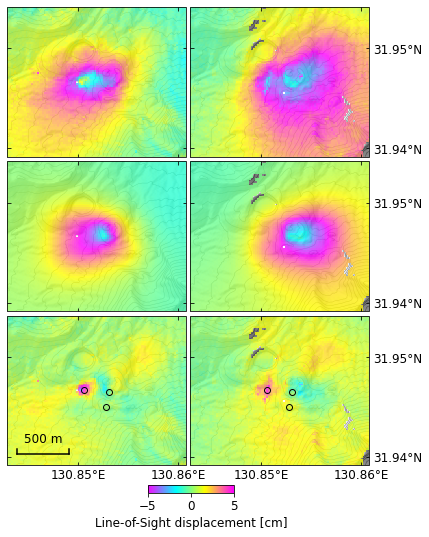

In [10]:
# input files
#defo_name, model_name = ds_list[-1].split('/')
#fnames = sorted(glob.glob(os.path.join(inv_res_dir, defo_name, model_name, 'Kirishima*.h5')))
mat_dir = os.path.dirname(mat_file)
fnames = sorted(glob.glob(os.path.join(mat_dir, 'Kirishima*.h5')))
print('HDF5 files:')
for fname in fnames:  print(fname)

# options for view.py
opt = ' --noverbose --notitle --nocbar --ref-size 2 --fontsize 12 ' #--notick
#opt += ' --sub-lat 31.936  31.956 --sub-lon 130.840 130.864 '
opt += ' --sub-lat 31.939  31.954 --sub-lon 130.843 130.861 '
opt += ' -u cm --wrap --wrap-range -5 5 -c cmy --noreference '
opt += ' --scalebar 0.3 0.20 0.075 --scalebar-pad 0.1 '
opt += ' --dem {} --contour-step 20 --contour-smooth 0.0 '.format(dem_file)
opt += ' --lalo-label --lalo-step 0.01 '

# plot
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=[6, 7.5], subplot_kw=dict(projection=ccrs.PlateCarree()))
for i, ds_name in enumerate(['data', 'model', 'residual']):

    # plot asc track
    ax = axs[i, 0]
    cmd = 'view.py {f} {d} {o} '.format(f=fnames[0], d=ds_name, o=opt)
    if ds_name != 'residual':
        cmd += ' --noscalebar --lalo-loc 0 0 0 0 '
    else:
        cmd += ' --lalo-loc 0 0 0 1 '
    data, atr, inps = view.prep_slice(cmd)
    ax, inps, im, cbar = view.plot_slice(ax, data, atr, inps)

    # plot asc track
    ax = axs[i, 1]
    cmd = 'view.py {f} {d} {o} --noscalebar '.format(f=fnames[1], d=ds_name, o=opt)
    if ds_name != 'residual':
        cmd += ' --lalo-loc 0 1 0 0 '
    else:
        cmd += ' --lalo-loc 0 1 0 1 '
    data, atr, inps = view.prep_slice(cmd)
    ax, inps, im, cbar = view.plot_slice(ax, data, atr, inps)
fig.tight_layout()
fig.subplots_adjust(wspace=0.02, hspace=-0.2)

# Points of Interest
lalo_list = [
    [31.9465, 130.8531],  # point C for Alos2DT23 - crater
    [31.9450, 130.8528],  # point S for Alos2DT23 - southern vent
    [31.9467, 130.8506],  # point W for Alos2DT23 - western vent
]
for ax in axs[-1,:]:
    for lalo in lalo_list:
        ax.plot(lalo[1], lalo[0], "ko", mew=1., mfc='none', ms=6)

# colorbar
cax = fig.add_axes([0.35, 0.04, 0.2, 0.015])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal', ticks=[-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Line-of-Sight displacement [cm]', fontsize=12)

#out_fig = os.path.join(work_dir, 'resid_Iwo2017post_{}.png'.format(os.path.basename(mat_dir).split('_')[-1]))
out_fig = os.path.join(work_dir, 'resid_Iwo2017post.png')
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=600)
print('save figure to file', out_fig)
plt.show()

## Backup: Decompose residual from asc/desc to horz/vert

get design matrix
incidence angle: 41.467650688375954
heading angle: 350.1998291015625
incidence angle: 34.52561084591047
heading angle: 190.38481903076172
project asc/desc into horz/vert direction


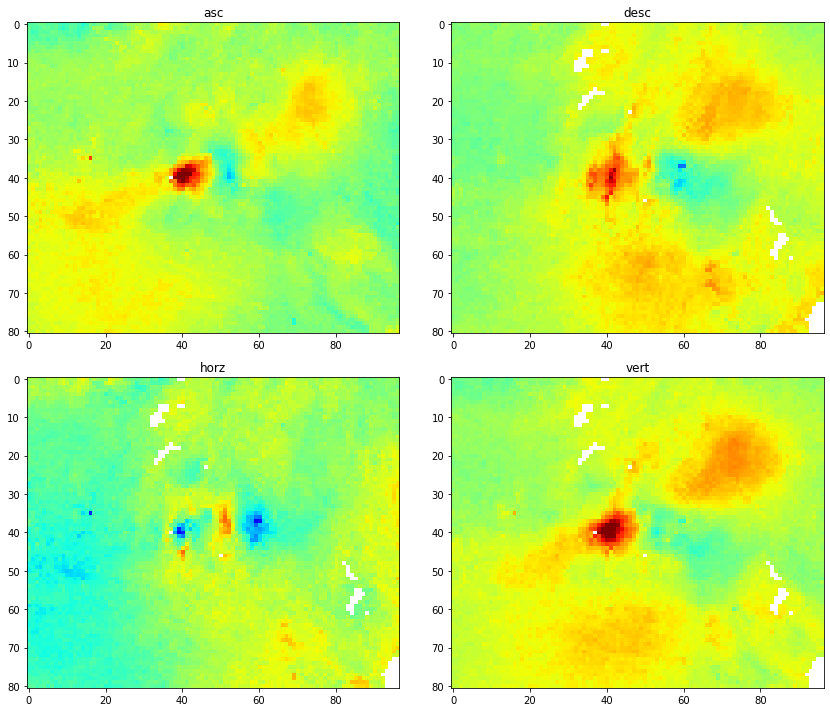

In [11]:
from mintpy import asc_desc2horz_vert
S, N, W, E = 31.939, 31.954, 130.843, 130.861
geo_box = (W, N, E, S)

fnames = sorted(glob.glob(os.path.join(os.path.dirname(mat_file), 'Kirishima*.h5')))
atr = readfile.read_attribute(fnames[0])
coord = ut.coordinate(atr)
pix_box = coord.box_geo2pixel(geo_box)
res1, atr1 = readfile.read(fnames[0], datasetName='residual', box=pix_box)
res2, atr2 = readfile.read(fnames[1], datasetName='residual', box=pix_box)
resH, resV = asc_desc2horz_vert.asc_desc2horz_vert(res1, res2, atr1, atr2)

# plot
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[12, 10])
kwargs = dict(vmin=-5, vmax=5, cmap='jet', interpolation='nearest')
for ax, res, title in zip(axs.flatten(), [res1, res2, resH, resV], ['asc', 'desc', 'horz', 'vert']):
    ax.imshow(res*100., **kwargs)
    ax.set_title(title)
fig.tight_layout()
plt.show()